In [10]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize

%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
class p:
    seed = 15
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/test'
    dset = 'gaussian' # gaussian
    beta_type = 'gaussian' # one_hot
    beta_norm = 1
    iid = 'iid' # 'iid', 'clustered', 'spike', decay, mult_decay
    dset_num = 1 # only matters for pmlb
    dset_name = ''
    reg_param = -1.0 # -1 use csv
    num_features = 100
    n_train_over_num_features = 3 # this and num_features sets n_train
    n_test = 100
    noise_std = 1
    noise_distr = 'gaussian' # gaussian, t, gaussian_scale_var, thresh
    model_type = 'ridge' # mdl_orig, 
    cov_param = 2

# vary lambda

In [12]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)

3it [00:02,  1.13it/s]
0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
2it [00:00,  2.20it/s]


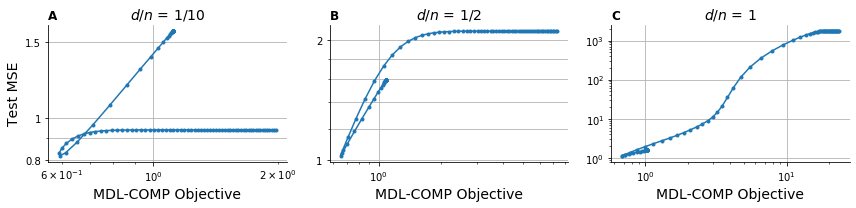

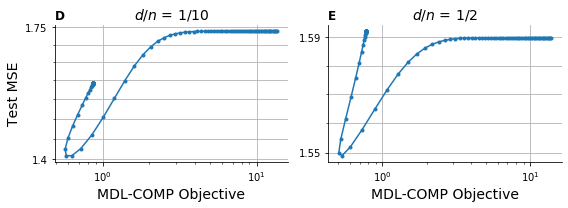

In [16]:
for top_or_bot in ['top', 'bot']:
    tits = ['1/10', '1/2', '1', '2', '10']
    if top_or_bot == 'top':
        R, C = 1, 3
        ratios = [10, 2, 1]
        plt.figure(figsize=(12, 3))
        lets = ['A', 'B', 'C']
    else:
        R, C = 1, 2
        ratios = [1/2, 1/10]
        plt.figure(figsize=(8, 3))
        lets = ['D', 'E']
    for c, n_train_over_num_features in tqdm(enumerate(ratios)): #, 1/2, 1/10])):
        p.n_train_over_num_features = n_train_over_num_features

        # warning - this reseeds!
        p.n_train = int(p.n_train_over_num_features * p.num_features)
        X_train, y_train, X_test, y_test, betastar = \
            data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                                noise_std=p.noise_std, noise_distr=p.noise_distr, iid=p.iid, # parameters to be determined
                                beta_type=p.beta_type, beta_norm=p.beta_norm, 
                                seed_for_training_data=p.seed, cov_param=p.cov_param)

        eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
        var = p.noise_std**2

        def calc_thetahat(l):
            inv = npl.pinv(X_train.T @ X_train + l * np.eye(p.num_features))
            return inv @ X_train.T @ y_train

        def mdl1_loss(l):
            thetahat = calc_thetahat(l)
            mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
            theta_norm = npl.norm(thetahat)**2 / (2 * var)
            eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
            return (mse_norm + theta_norm + eigensum) / y_train.size


        lambdas = np.logspace(-10, 10, num=100)
        n = lambdas.size


        r = {
            'l': lambdas,
            'mdl1': np.zeros(n),
            'test_mse': np.zeros(n)
        }
        for i, l in enumerate(lambdas):
            thetahat = calc_thetahat(l)
            r['test_mse'][i] = np.mean(np.square(y_test - X_test @ thetahat))
            r['mdl1'][i] = mdl1_loss(l)
        ax = plt.subplot(R, C, c + 1)
        plt.plot(r['mdl1'], r['test_mse'], '.-')

        plt.tight_layout()

        if c == 0:
            plt.ylabel('Test MSE', fontsize=14)

        plt.xscale('log')
        plt.yscale('log')
        plt.grid(which='major', axis='x')      
        plt.grid(which='both', axis='y')    
    #     plt.grid(which='major', axis='y')    

        ax.yaxis.set_minor_formatter(NullFormatter())

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if n_train_over_num_features == 10:
            plt.yticks([0.8, 1, 1.5], labels=['0.8', '1', '1.5'])    
        if n_train_over_num_features == 2:
            plt.yticks([1, 2], labels=['1', '2'])  
        if n_train_over_num_features == 1:
            plt.grid(which='minor', axis='y')    
        elif n_train_over_num_features == 1/2:
            plt.yticks([1.4, 1.75], labels=['1.4', '1.75'])
        elif n_train_over_num_features == 1/10:
            plt.yticks([1.55, 1.59], labels=['1.55', '1.59'])
        plt.xlabel('MDL-COMP Objective', fontsize=14)
        plt.title('$d/n$ = ' + tits[c], fontsize=14)
        plt.title(lets[c], loc='left', fontweight='bold')

    # plt.savefig(oj(save_dir, 'fig_lambda_top.pdf'))
    plt.savefig(oj(save_dir, f'fig_lambda_{top_or_bot}.pdf'))